# Imports required

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import torch.optim as optim

# !pip install deap

from deap import base
from deap import benchmarks
from deap import creator
from deap import tools

import operator
import random

import math

Loading in CIFAR-10

In [2]:
# The dataset comes in data of the range 0-1, we want to convert this to -1 to 1 as part of normalisation

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Function to transform the dataset to the specified range

batch_size = 512

# Downloading the training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Loading the training set into a variable
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# etc.
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Specifying the classes of the dataset that we want to train the classifier on
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Testing for GPU

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


Testing to see if we can see the images

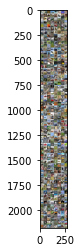

plane bird  frog  bird  plane plane bird  truck truck cat   horse horse frog  car   bird  dog   plane cat   dog   car   plane plane cat   frog  ship  truck horse bird  truck horse deer  plane deer  ship  frog  ship  car   frog  dog   horse plane truck plane dog   horse frog  frog  ship  ship  ship  frog  horse bird  deer  deer  deer  cat   ship  deer  dog   deer  bird  bird  horse ship  dog   truck truck bird  horse bird  frog  truck bird  bird  frog  truck frog  deer  deer  car   horse plane deer  horse car   bird  deer  truck frog  car   plane ship  plane ship  bird  truck ship  bird  bird  horse plane frog  frog  cat   frog  dog   ship  dog   plane car   car   bird  plane frog  bird  horse deer  horse horse frog  truck dog   cat   plane bird  car   car   car   bird  bird  truck horse horse horse cat   cat   deer  ship  horse truck horse plane dog   cat   deer  car   dog   bird  dog   cat   bird  frog  plane truck truck cat   bird  bird  bird  plane bird  frog  car   horse deer  car 

In [4]:
# functions to show an image for fun


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Building network definition

In [5]:
# Relu is a fast output function

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)

        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model=Net()

In [6]:
#Upload GD_Model.pth to the session to act as pre-defined network
# from google.colab import files
# files.upload()

Loading in the model

In [7]:
PATH = ('./GD_Model.pth')
PopModel = Net()
PopModel.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [8]:
# Setting all layers to not change their weights with GD backpropagation

for param in PopModel.parameters():
    # By setting the requires grad for each parameter to false, we no longer track it with autograd
    # Consequently, backpropagation or whatever will not compute the gradients for these layers
    param.requires_grad = False

Getting the final layer

In [9]:
finalLayer = list(PopModel.children())[-1]

print(finalLayer) # 10 features out

print(len(finalLayer.weight)) # 10 population size


print(len(finalLayer.weight[0])) # 10 arrays, with 84 items in it

# 84 inputs connected to a single output, there are 10 outputs therefore 84x10 connections in total. for one output, the 84 connections will have 84 different weights which are used
# to calculate the output node. therefore there are 10 tensors with 84 elements in each tensor, with a different set of weights.

# print(finalLayer.weight)

#print(finalLayer.weight) # Layer requires 840 connections

print(len(finalLayer.bias))

paramCount = sum(param.numel() for param in finalLayer.parameters())

print(paramCount) # 850 Parameters: 840 weights + 10 biases

sk= torch.max(((finalLayer.weight).reshape(840,)))

print(sk)

Linear(in_features=84, out_features=10, bias=True)
10
84
10
850
tensor(0.4984)


In [10]:
# Randomise final layer weights



nn.init.xavier_uniform(finalLayer.weight)

#print(finalLayer.weight)

print((finalLayer.weight).shape) # Shape that the layer requires is (10,84)

print((finalLayer.bias).shape)

torch.Size([10, 84])
torch.Size([10])


<ipython-input-10-0638b396f9c2>:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(finalLayer.weight)


In [11]:
# Converting weights to a numpy array

def convert_np_function(self, intermediate_tensor):
        intermediate_value = intermediate_tensor.numpy()
        self.intermediate_values.append(intermediate_value)

populationList = finalLayer.weight.numpy()

#print(populationList) # Converted to Numpy

Defining PSO functions

In [12]:
posMinInit      = -3
posMaxInit      = + 5
VMaxInit        = 1.5
VMinInit        = 0.5
# populationSize  = 3
dimension       = 850
populationSize  = 100+int(dimension/10) # from lab on SL-PSO
#interval        = 10
interval = 1
iterations      = 100

#variables used in SL-PSO
epsilon = dimension/100.0*0.01 # social influence of swarm centre

#Parameter setup -- these are not used in SL-PSO
wmax = 0.9 #weighting
wmin = 0.4
c1   = 2.0
c2   = 2.0

# Criterion for measuring loss, may need to tweak this to return negative value for PSO
criterion = nn.CrossEntropyLoss()

# Values used for the Gaussian Mutation
sigmaValue = 0.5
muValue = 0

# Standard deviation of the population should be below this number to start mutation
MutationStart = 1.0

In [13]:
# function to get the mean positions of the inviduals (swarm centre)
def getcenter(pop):
    center=list()
    for j in range(dimension): # count through dimensions
        centerj = 0
        for i in pop: # for each particle
            centerj += i[j] # sum up position in dimention j
        centerj /= populationSize # Average
        center.append(centerj)
    return center

creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # -1 is for minimise
creator.create("Particle", list, fitness=creator.FitnessMin, speed=list, smin=None, smax=None, best=None)

In [14]:
# particle rerpresented by list of 5 things
# 1. fitness of the particle,
# 2. speed of the particle which is also going to be a list,
# 3.4. limit of the speed value,
# 5. best state the particle has been in so far.

def generate(size, smin, smax):
    part = creator.Particle(random.uniform(posMinInit, posMaxInit) for _ in range(size))
    part.speed = [random.uniform(VMinInit, VMaxInit) for _ in range(size)]
    part.smin = smin #speed clamping values
    part.smax = smax
    return part

def updateParticle(part,pop,center,i):
    r1 = random.uniform(0, 1)
    r2 = random.uniform(0, 1)
    r3 = random.uniform(0, 1)

    #Randomly choose a demonstrator for particle i from any of particles 0 to i-1, the Particle i
    #updates its velocity by learning from the demonstrator and the mean position of the swarm
    demonstrator=random.choice(list(pop[0:i]))

    for j in range(dimension): # count through dimensions
        part.speed[j]=r1*part.speed[j]+r2*(demonstrator[j]-part[j])+r3*epsilon*(center[j]-part[j])
        part[j]=part[j]+part.speed[j]


# Euclidean Distance used for mutation
def euclideanDistance(ind1, ind2):
  distance = (ind1 - ind2)**2
  return math.sqrt(distance)

# Used to rescale distances between 0 and 1, with lower distances being scaled closer to 1.
def rescaler(distances):
  scaled = [1 / (d + 1) for d in distances]

  return scaled

In [15]:
toolbox = base.Toolbox()
toolbox.register("particle", generate, size=dimension, smin=-3, smax=3)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)
toolbox.register("update", updateParticle)

# Note most likely need to change the evaluate function
toolbox.register("evaluate", benchmarks.sphere) #sphere function is built-in in DEAP

# def sphere(individual):
#     r"""Sphere test objective function.

#     .. list-table::
#        :widths: 10 50
#        :stub-columns: 1

#        * - Type
#          - minimization
#        * - Range
#          - none
#        * - Global optima
#          - :math:`x_i = 0, \forall i \in \lbrace 1 \ldots N\rbrace`, :math:`f(\mathbf{x}) = 0`
#        * - Function
#          - :math:`f(\mathbf{x}) = \sum_{i=1}^Nx_i^2`
#     """
#     return sum(gene * gene for gene in individual), # How does this work?, return one value or return a list?

# the line above returns one value

runCounter = 0

def modelEval(particle, runCounter):
    runCounter = runCounter
    runCounter +=1
    #print("hello!")

    # First step to get the particles weights out from it, convert to an numpy array
    particleweightsNP1 = np.array(particle)

    particleweightsNP = particleweightsNP1[:840]
    biases = np.array(particleweightsNP1[-10:])

    # Putting biases straight in
    biases = torch.from_numpy(biases).float()
    finalLayer.bias = torch.nn.Parameter(biases.float())

    #print(particleweightsNP)

#     print("Shape of particle: " + str(particleweightsNP.shape))

    # Converting to the correct shape!
    reshapedWeights = particleweightsNP.reshape(10,84)
#     print("Shape of reshaped particle: " + str(reshapedWeights.shape))

    # Convert to torch array!
    torchWeights = torch.from_numpy(reshapedWeights).float()

    # Now we want to set the weights of the finalLayer to these weights

    finalLayer.weight = torch.nn.Parameter(torchWeights.float())

    # print("After:\n")
    # print(finalLayer.weight)

    #finalLayer.weight.data = torchWeights.float()
    #print(finalLayer.weight) # Note that the numbers look different than torchWeights ?
    #print(torchWeights)

    # Run a training loop for the model, with the particles weights set to the final layer and return a loss value back

    epoch_loss = 0.0
    running_loss = 0.0

    # reshapedWeights.to(device)
    # torchWeights.to(device)

#     print(f"Starting training run {runCounter}...")

    PopModel.to(device)

    for epoch in range(1):

        epoch_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # Getting the predictions for the model
            outputs = PopModel(inputs)

            loss = criterion(outputs, labels)

            #print(loss.item())

            epoch_loss += loss.item()

#         print("End of Epoch:" + str(epoch))

        running_loss += (epoch_loss / i)

    # Now we have a loss value:
    print("Total Loss: " + str(running_loss))

    return running_loss, # This may be the wrong this to pass back, one test run showed loss is 835852, remember to check that it definitely doesnt update through gradient!

    # High loss could be due to how the weights were initialised or how they were converted between numpy and torch tensor?

    # We need to return one value

    #object of type 'NoneType' has no len() # Error when not returning anything.
    #object of type 'float' has no len() # Error when returning_loss by itself, investigate the output of the original sphere function?

    # Original loss function returns a single value. example output looks like (136.3042681576523,)

    # Do you need to return a list, with each epoch loss in there?
    # Doing this: Assigned values have not the same length than fitness weights
    # Update: Do not return a list

toolbox.register("evaluate2", modelEval)

In [16]:
def main():
    pop = toolbox.population(n=populationSize) # Population Size
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    #intialize the learning probabilities
    prob=[0]*populationSize
    for i  in range(len(pop)):
        prob[populationSize - i - 1] = 1 - i/(populationSize - 1)
        prob[populationSize - i - 1] = pow(prob[populationSize - i - 1], math.log(math.sqrt(math.ceil(dimension/100.0))))

    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields

    #begin main loop
    for g in range(iterations):

        for part in pop:
            part.fitness.values = toolbox.evaluate2(part, runCounter) #actually only one fitness value

        #Sort the individuals in the swarm in ascending order. i.e., particle 0 is the best

        # sortedPop = pop

        pop.sort(key=lambda x: x.fitness, reverse=True)
        #calculate the center (mean value) of the swarm
        center = getcenter(pop)

        # Code to update particle via velocity
        for i  in reversed(range(len(pop)-1)):  # start with worst particle, and go in reverse towards best
                                                # don't do element 0 (best). Hence the i+1 below.
            if random.uniform(0, 1)<prob[i+1]: #learning probability for that particle
                toolbox.update(pop[i+1],pop,center,i+1)

        # Gather all the fitnesses in one list and print the stats
        # print every interval
        if g%interval==0: # interval
            logbookRecord = logbook.record(gen=g, evals=len(pop), **stats.compile(pop))
            print(logbook.stream)

        # Creating the mutation aspect
        stdev = logbook.select("std")
        # Get the latest standard deviation metric
        latestStd = stdev[-1]

        # # Sort the population again for now.
        # sortedPop.sort(key=lambda x: x.fitness, reverse=True)

        # for i in sortedPop:
        #   print(i.fitness.values[0]) # Print out the sorted fitness values


        # print("best:"+str(pop[0].fitness.values[0]))
        # for i in pop:
        #   print(i.fitness.values[0])


        # We want to start mutation if we know the particles are starting to converge, this will be when standard deviation of the population drops below a certain value

        if latestStd < MutationStart:
          print("Starting Mutation of Particles")

          # Get the best fitness value out:
          bestParticle = pop[0].fitness.values[0]

          # Calculate a list of euclidean distances
          distances = []

          # Loops through population apart from the first value as we dont need to calculate the distance for the first particle as it is already the best
          for i in pop[1:]:
            individualFitness = i.fitness.values[0]
            distances.append(euclideanDistance(bestParticle, i.fitness.values[0]))
          #print(distances)

          # Apply a function to the distance list to map them between 0 and 1, we want the smaller EDs to have a bigger probability
          # Then apply deap mutate function to the particles with their corresponding calculated probability of mutation
          probs = rescaler(distances)

          #print(probs)

          # Iterate through both population and the probability list and mutate with the probabilities
          # Important, may need to adjust the value of sigma and mu accordingly as this is gaussian distribution

          # Larger sigma = more exploration, smaller = more exploitation
          # Mu controls the bias of the spread

          # Attempting to mutate!
          for i, p in zip(pop[1:], probs):
            tools.mutGaussian(i, mu=muValue, sigma=sigmaValue, indpb=p)




    return pop, logbook

if __name__ == "__main__":
    superpart = main()

Total Loss: 37.08078958570343
Total Loss: 36.59822106115597
Total Loss: 34.68195561281185
Total Loss: 34.7913063285277
Total Loss: 42.3134997652978
Total Loss: 37.814009754928115
Total Loss: 33.63479803026337
Total Loss: 35.63693724956709
Total Loss: 36.104145207355934
Total Loss: 32.50788285560215
Total Loss: 29.229045474652164
Total Loss: 33.033913740177745
Total Loss: 34.28439038070207
Total Loss: 34.77119583444497
Total Loss: 37.93256216934047
Total Loss: 40.6003596119045
Total Loss: 33.70966081520946
Total Loss: 38.835928966089625
Total Loss: 41.86140190203165
Total Loss: 35.68128918126686
Total Loss: 44.289865906705565
Total Loss: 36.48247823026991
Total Loss: 36.04399671259615
Total Loss: 31.857122637561915
Total Loss: 40.20547131410579
Total Loss: 33.482681628355046
Total Loss: 41.375941915610404
Total Loss: 34.01683653998621
Total Loss: 32.37245520365607
Total Loss: 37.00555463181328
Total Loss: 29.216584313776075
Total Loss: 35.78260771761236
Total Loss: 33.0081336031255
Tota

In [17]:
print(len(superpart[1])) # best particle has 840 weights in it
print(superpart[1]) 
arr = np.array(superpart[1])

print(arr.shape)

import csv

with open('superpart-030.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerows([superpart[0][0]])
    
with open('logbook-030.csv', 'a', newline='') as file:
    writer = csv.writer(file)
#     writer.writerows(["gen","evals","avg","std","min","max"])
    writer.writerows([superpart[1].select("gen"),superpart[1].select("evals"),superpart[1].select("avg"),
                      superpart[1].select("std"),superpart[1].select("min"),superpart[1].select("max")])

100
gen	evals	avg    	std     	min    	max    
0  	185  	37.0767	4.48656 	25.6847	51.0442
1  	185  	32.5541	4.75324 	18.6497	44.4134
2  	185  	27.8948	5.43796 	17.1873	61.0391
3  	185  	25.2645	7.24097 	15.298 	67.646 
4  	185  	23.6932	8.43428 	12.3722	67.0577
5  	185  	22.7694	8.8061  	11.3034	57.5669
6  	185  	21.3085	8.19354 	10.4457	62.0422
7  	185  	19.2722	7.18375 	8.17269	45.4382
8  	185  	17.9759	7.19616 	8.17532	41.511 
9  	185  	17.2001	8.18986 	7.55888	54.6383
10 	185  	15.9791	7.41433 	7.55905	52.0661
11 	185  	14.7456	6.43838 	7.26985	40.4245
12 	185  	14.0166	7.0404  	6.6944 	58.4312
13 	185  	13.1394	6.48591 	6.61419	47.0865
14 	185  	12.2833	5.6269  	6.5395 	44.494 
15 	185  	11.1142	5.03612 	6.08065	46.0564
16 	185  	10.4657	4.89408 	5.50272	42.263 
17 	185  	9.69183	4.26011 	5.17564	31.5881
18 	185  	9.05087	4.08792 	5.08733	39.49  
19 	185  	8.39582	3.59066 	5.08484	38.3581
20 	185  	7.95706	3.17297 	4.4328 	29.8458
21 	185  	7.37842	2.82304 	4.34179	24.9702
22 	185

In [18]:
# Put in the bestparticle like this superPart[2] (format to get the best particle after running main)
def evaluateBest(bestParticle):
  bestNP = np.array(bestParticle)

  # Splitting into weights and biases

  bestWeights = bestNP[:840]
  bestBiases = bestNP[-10:]

  # Putting biases in
  bestBiases = torch.from_numpy(bestBiases).float()
  finalLayer.bias = torch.nn.Parameter(bestBiases.float())

  # Reshaping weights so they are correct for the layer
  bestWeights = bestWeights.reshape(10,84)

  # Converting to torch array
  bestWeights = torch.from_numpy(bestWeights).float()

  # Putting the weights into the layer

  finalLayer.weight = torch.nn.Parameter(bestWeights.float())


  # Evaluating the best particle on the test set

  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  # Move the model onto GPU again? Most likely do not need to as it should already be in the GPU

  for data in testloader:
    images, labels = data
    outputs = PopModel(images)

    _, predictions = torch.max(outputs, 1)

    # collect the correct predictions for each class

    for label, prediction in zip(labels, predictions):
      if label == prediction:
        correct_pred[classes[label]] += 1
      total_pred[classes[label]] += 1

  # Printing the results
  for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')